In [33]:
import tensorflow as tf
from vit_keras import vit, utils, visualize
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from IPython.display import Image
from IPython.core.display import display, HTML
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

import os 
import pandas as pd
import numpy as np
import darwin
import json
import time
import re
import itertools
import pickle
import csv
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
''' REQUIRED Variables '''

def create_dict(*args):
    return dict({i:eval(i) for i in args})

###

dataset_loc = "/home/ubuntu/Data/MedImage/ViT_Train_3_weights/"
JSON_PATH = dataset_loc+"ViT_IDC.json"
MODEL_WEIGHTS = dataset_loc+"ViT_IDC_Weights.0.35.h5"

data_1 = create_dict("dataset_loc", "JSON_PATH", "MODEL_WEIGHTS")


In [8]:
''' Helper Functions '''
    
### This will pull the json tags from the files downloaded from V7
### And write them into the dataframe that lists the full image path and full json path

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Tweaked from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
# Changed the percent calculation to be the percent within each class, IE accuracy for each class
# Before it was calculating the percent within that box, which is kinda of not useful
# Fixed the color score to be based on percentages when colored, instead of the counts

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    Percent:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html            
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        # The original percent calculation is here, but its no good
        # group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
        # Fixed below
        cm_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
        group_percentages = cm_norm.flatten()
        group_percentages = np.around(group_percentages, 2)
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # Fix to color by percentages
    if percent:
        cf = cm_norm
        
    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)
        
def load_model(JSON_PATH, MODEL_WEIGHTS):
    """
    :param COND_MODEL_JSON_PTH: (str) path to json model file
    :param COND_MODEL_WEIGHTS_PTH:  (str) path to model weights file
    :return: condition model
    """
    cond_json_file = open(JSON_PATH, "r")
    cond_loaded_model_json = cond_json_file.read()
    cond_json_file.close()
    cond_model = tf.keras.models.model_from_json(cond_loaded_model_json)
    # load weights into new model
    cond_model.load_weights(MODEL_WEIGHTS)
    print("type of cond model", type(cond_model))
    return cond_model

def image_inference(img_pth, model, image_size = 64):
    """
    :param img_pth: (str) path to image file for inference
    :return: (float) condition score for image
    """
    img = tf.keras.preprocessing.image.load_img(img_pth, target_size=(image_size, image_size))
    x = tf.keras.preprocessing.image.img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
    x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
    x = x / 255
    result = model.predict(x, batch_size=1)
    result = result[0]
    return(result)

In [7]:
''' MODEL 1 LOAD DATA RESULTS '''

int_data = data_1

text_file = open(int_data["dataset_loc"] + "MODEL_PARAMETERS.txt", "r")
MODEL_PARAMETERS = text_file.read()
text_file.close()

MODEL_PARAMETERS = eval(MODEL_PARAMETERS)
MODEL_PARAMETERS

model = load_model(int_data["JSON_PATH"], int_data["MODEL_WEIGHTS"])

val_df = pd.read_csv(int_data["dataset_loc"] + "val_data.csv", index_col=0)
print(Counter(val_df["class_membership"]))
val_df.reset_index(inplace=True, drop = True)
val_df.head()

type of cond model <class 'keras.engine.functional.Functional'>
Counter({0: 8671, 1: 6870})


,patient_id,image_path,class_membership,assignment
0,9324,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation
1,9254,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation
2,9323,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation
3,9291,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation
4,9319,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation


In [22]:
''' MODEL 1 MAKE PREDICTIONS'''

classes = ["0", "1"]

val_df["Prediction"] = "NA"
    
#for idx in val_df.index[0:3]: 
    #predict = image_inference(val_df["image_path"][idx], model)
    
    
predict_list = []
idc_list = []
class_prediction_list = []

for idx, img in enumerate(val_df["image_path"]): 
    
    
    if idx % 100 == 0:
        print("Starting idx " + str(idx))
    
    predict = image_inference(img, model)
    predict = predict[0]
    predict_list.append(predict)
    
    if predict[0] < 0.5:
        idc_list.append("IDC-")
        class_prediction_list.append("0")

    else :
        idc_list.append("IDC+")
        class_prediction_list.append("1")
    
    '''
    Requires Pyton 3.7 - 3.8
    val_df._set_value(idx, "Prediction", predict)

    if predict[0] < 0.5:
        val_df._set_value(idx, "IDC", "IDC-")
        val_df._set_value(idx, "class_prediction", "0")
    else :
        val_df._set_value(idx, "IDC", "IDC+")
        val_df._set_value(idx, "class_prediction", "1")
    '''
    



Starting idx 0
Starting idx 100
Starting idx 200
Starting idx 300
Starting idx 400
Starting idx 500
Starting idx 600
Starting idx 700
Starting idx 800
Starting idx 900
Starting idx 1000
Starting idx 1100
Starting idx 1200
Starting idx 1300
Starting idx 1400
Starting idx 1500
Starting idx 1600
Starting idx 1700
Starting idx 1800
Starting idx 1900
Starting idx 2000
Starting idx 2100
Starting idx 2200
Starting idx 2300
Starting idx 2400
Starting idx 2500
Starting idx 2600
Starting idx 2700
Starting idx 2800
Starting idx 2900
Starting idx 3000
Starting idx 3100
Starting idx 3200
Starting idx 3300
Starting idx 3400
Starting idx 3500
Starting idx 3600
Starting idx 3700
Starting idx 3800
Starting idx 3900
Starting idx 4000
Starting idx 4100
Starting idx 4200
Starting idx 4300
Starting idx 4400
Starting idx 4500
Starting idx 4600
Starting idx 4700
Starting idx 4800
Starting idx 4900
Starting idx 5000
Starting idx 5100
Starting idx 5200
Starting idx 5300
Starting idx 5400
Starting idx 5500
Star

In [24]:
val_df["Prediction"] = predict_list
val_df["IDC"] = idc_list
val_df["class_predict"] = class_prediction_list

val_df

,patient_id,image_path,class_membership,assignment,Prediction,IDC,class_predict
0,9324,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,[0.08913242],IDC-,0
1,9254,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,[0.002832119],IDC-,0
2,9323,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,[0.046926722],IDC-,0
3,9291,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,[0.096874915],IDC-,0
4,9319,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,[0.014927153],IDC-,0
...,...,...,...,...,...,...,...
15536,9324,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,1,validation,[0.9713624],IDC+,1
15537,9250,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,1,validation,[0.9700753],IDC+,1
15538,9258,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,1,validation,[0.675533],IDC+,1
15539,9259,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,1,validation,[0.8297941],IDC+,1


Accuracy Score is 0.8518113377517534
              precision    recall  f1-score   support

           0       0.94      0.79      0.86      8671
           1       0.78      0.93      0.85      6870

    accuracy                           0.85     15541
   macro avg       0.86      0.86      0.85     15541
weighted avg       0.87      0.85      0.85     15541

None


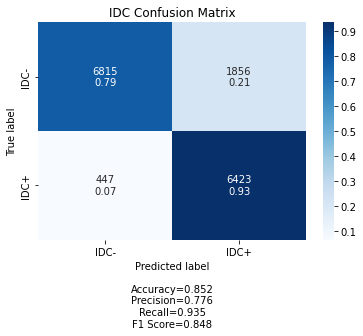

In [45]:
''' MODEL 1 QC PREDICTIONS'''

val_df["class_membership"] = val_df["class_membership"].astype(str)


truth = val_df["class_membership"]
prediction = val_df["class_predict"]

correct_labels = truth == prediction
val_df["Correct"] = correct_labels
Counter(val_df["Correct"])

print(color.GREEN + "Accuracy Score is " + str(accuracy_score(truth, prediction)))
    
print(color.GREEN + classification_report(truth, prediction))
    
cf_matrix = confusion_matrix(truth, prediction)
    
print(make_confusion_matrix(cf_matrix, percent = True, count= True, categories = ["IDC-", "IDC+"], title = "IDC Confusion Matrix"))

In [47]:
val_df

,patient_id,image_path,class_membership,assignment,Prediction,IDC,class_predict,Correct
0,9324,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,0.089132,IDC-,0,True
1,9254,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,0.002832,IDC-,0,True
2,9323,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,0.046927,IDC-,0,True
3,9291,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,0.096875,IDC-,0,True
4,9319,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,0,validation,0.014927,IDC-,0,True
...,...,...,...,...,...,...,...,...
15536,9324,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,1,validation,0.971362,IDC+,1,True
15537,9250,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,1,validation,0.970075,IDC+,1,True
15538,9258,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,1,validation,0.675533,IDC+,1,True
15539,9259,/home/ubuntu/Data/MedImage/IDC_regular_ps50_id...,1,validation,0.829794,IDC+,1,True


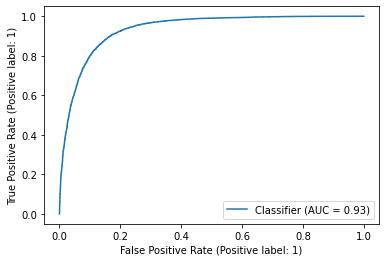

In [52]:
RocCurveDisplay.from_predictions(truth, val_df["Prediction"], pos_label = "1")

In [32]:
with open(int_data["dataset_loc"]+"trainHistoryDict", 'rb') as pickle_file:
    history = pickle.load(pickle_file)

EOFError: Ran out of input

In [ ]:
plt.plot(history['loss'], color = "blue")
plt.plot(history['val_loss'],color = "blue", ls = "dashed")
                      
plt.title('model performance')
plt.ylabel('Metric Value')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()